# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [ ]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
#settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")
#settings = config.HopsworksSettings()
#read the API keys

Local environment
Added the following directory to the PYTHONPATH: /Users/selinaliu/Desktop/大四上/DL/mlfs-book
HopsworksSettings initialized!


In [2]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util
import os

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 10, 12, 47, 58, 475816)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [ ]:
import argparse, json

parser = argparse.ArgumentParser()
parser.add_argument("--id", type=int, default=1)
args, _ = parser.parse_known_args()
id=args.id

In [ ]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret(f"SENSOR_{id}_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-10 12:47:58,486 INFO: Initializing external client
2025-11-10 12:47:58,487 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-10 12:47:59,106 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-10 12:48:00,225 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1279139


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [ ]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name=f"air_quality_xgboost_model_{id}",
    version=1,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-10 12:48:05,296 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/491674 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/113422 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26057 elapsed<00:00 remaining<?

In [ ]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + f"/model_{id}.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='3.068322E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [ ]:
weather_fg = fs.get_feature_group(
    name=f'weather_{id}',
    version=1,
)
air_quality_fg = fs.get_feature_group(
    name=f'air_quality_{id}',
    version=2,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()

batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.95s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-11 00:00:00+00:00,7.85,0.0,7.386582,226.974930,stockholm
1,2025-11-12 00:00:00+00:00,10.15,0.0,26.795223,173.829926,helsingborg
2,2025-11-11 00:00:00+00:00,9.00,0.1,20.192118,191.309891,helsingborg
3,2025-11-14 00:00:00+00:00,13.55,0.4,22.424271,227.602615,helsingborg
4,2025-11-13 00:00:00+00:00,13.30,0.0,26.596178,230.492355,helsingborg


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [ ]:
import numpy as np
import datetime

# Initialisation
for lag in range(1, 4):
    batch_data[f"pm25_lag_{lag}"] = np.nan
batch_data["predicted_pm25"] = np.nan

today = datetime.date.today()
today= today.strftime("%Y-%m-%d")

today =pd.Timestamp(f"{today} 00:00:00+00:00",tz='UTC')
#fill first row
for lag in [1, 2, 3]:
    date_to_fetch = today - pd.Timedelta(days=lag-1)
    feature_name = f"pm25_lag_{lag}"
    
    filtered_df = air_quality_fg.filter(
        (air_quality_fg.date >= date_to_fetch) &
        (air_quality_fg.date < date_to_fetch + pd.Timedelta(days=1))
    ).read()
    
    if not filtered_df.empty:
        batch_data.loc[0, feature_name] = filtered_df.loc[0, feature_name]


cols = ["pm25_lag_1","pm25_lag_2","pm25_lag_3",
        "temperature_2m_mean","precipitation_sum",
        "wind_speed_10m_max","wind_direction_10m_dominant"]

# prediction of first row
batch_data.loc[0, "predicted_pm25"] = retrieved_xgboost_model.predict(
    batch_data.loc[[0], cols]  
)[0]

for i, row in batch_data.iterrows():
    if i == 0:
        continue
    
    batch_data.loc[i, "pm25_lag_1"] = batch_data.loc[i-1, "predicted_pm25"]
    batch_data.loc[i, "pm25_lag_2"] = batch_data.loc[i-1, "pm25_lag_1"]
    batch_data.loc[i, "pm25_lag_3"] = batch_data.loc[i-1, "pm25_lag_2"]
    
    batch_data.loc[i, "predicted_pm25"] = retrieved_xgboost_model.predict(
        batch_data.loc[[i], cols] 
    )[0]

batch_data


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.83s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.86s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.85s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,predicted_pm25
0,2025-11-11 00:00:00+00:00,7.85,0.0,7.386582,226.974930,stockholm,24.000000,19.000000,28.000000,30.150118
1,2025-11-12 00:00:00+00:00,10.15,0.0,26.795223,173.829926,helsingborg,30.150118,24.000000,19.000000,32.540771
2,2025-11-11 00:00:00+00:00,9.00,0.1,20.192118,191.309891,helsingborg,32.540771,30.150118,24.000000,32.880978
3,2025-11-14 00:00:00+00:00,13.55,0.4,22.424271,227.602615,helsingborg,32.880978,32.540771,30.150118,26.389242
4,2025-11-13 00:00:00+00:00,13.30,0.0,26.596178,230.492355,helsingborg,26.389242,32.880978,32.540771,27.771332


In [9]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         5 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          5 non-null      float32                
 2   precipitation_sum            5 non-null      float32                
 3   wind_speed_10m_max           5 non-null      float32                
 4   wind_direction_10m_dominant  5 non-null      float32                
 5   city                         5 non-null      object                 
 6   pm25_lag_1                   5 non-null      float64                
 7   pm25_lag_2                   5 non-null      float64                
 8   pm25_lag_3                   5 non-null      float64                
 9   predicted_pm25               5 non-null      float64                
dtypes: dat

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [10]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-11 00:00:00+00:00,7.85,0.0,7.386582,226.974930,helsingborg,24.000000,19.000000,28.000000,30.150118,drottninggatan,sweden,1
2,2025-11-11 00:00:00+00:00,9.00,0.1,20.192118,191.309891,helsingborg,32.540771,30.150118,24.000000,32.880978,drottninggatan,sweden,3
1,2025-11-12 00:00:00+00:00,10.15,0.0,26.795223,173.829926,helsingborg,30.150118,24.000000,19.000000,32.540771,drottninggatan,sweden,2
4,2025-11-13 00:00:00+00:00,13.30,0.0,26.596178,230.492355,helsingborg,26.389242,32.880978,32.540771,27.771332,drottninggatan,sweden,5
3,2025-11-14 00:00:00+00:00,13.55,0.4,22.424271,227.602615,helsingborg,32.880978,32.540771,30.150118,26.389242,drottninggatan,sweden,4


In [11]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 0 to 3
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         5 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          5 non-null      float32                
 2   precipitation_sum            5 non-null      float32                
 3   wind_speed_10m_max           5 non-null      float32                
 4   wind_direction_10m_dominant  5 non-null      float32                
 5   city                         5 non-null      object                 
 6   pm25_lag_1                   5 non-null      float64                
 7   pm25_lag_2                   5 non-null      float64                
 8   pm25_lag_3                   5 non-null      float64                
 9   predicted_pm25               5 non-null      float64                
 10  street     

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2025-11-10 12:48:18,247 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



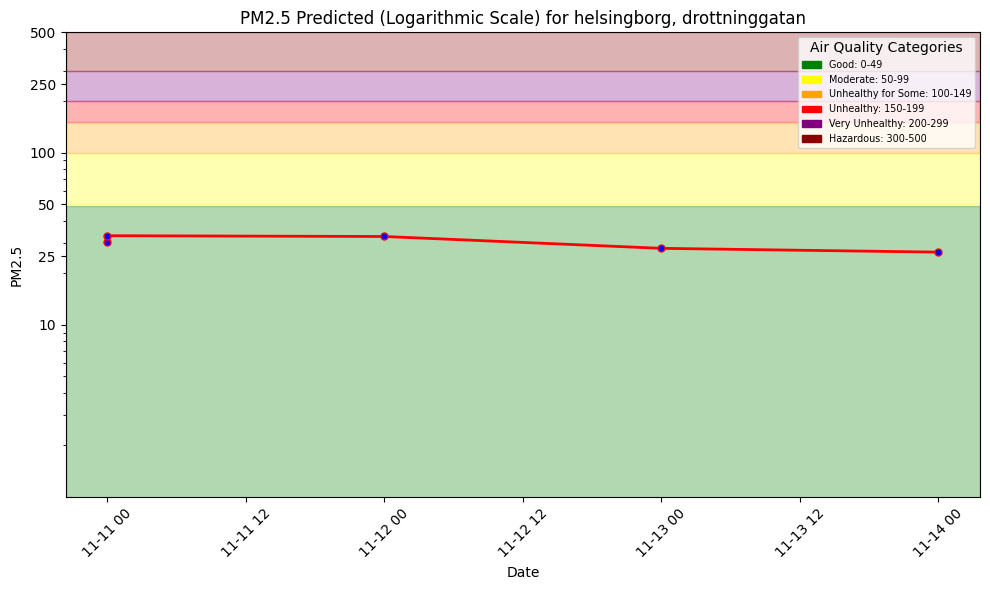

In [ ]:

pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast_{id}.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

plt.show()

In [ ]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name=f'aq_predictions_{id}',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [15]:
# Convert data types to match Hopsworks feature group schema (float32 instead of float64/double)
batch_data['pm25_lag_1'] = batch_data['pm25_lag_1'].astype('float32')
batch_data['pm25_lag_2'] = batch_data['pm25_lag_2'].astype('float32')
batch_data['pm25_lag_3'] = batch_data['pm25_lag_3'].astype('float32')
batch_data['predicted_pm25'] = batch_data['predicted_pm25'].astype('float32')

print("Data types after conversion:")
print(batch_data[['pm25_lag_1', 'pm25_lag_2', 'pm25_lag_3', 'predicted_pm25']].dtypes)

monitor_fg.insert(batch_data, wait=True)

Data types after conversion:
pm25_lag_1        float32
pm25_lag_2        float32
pm25_lag_3        float32
predicted_pm25    float32
dtype: object


Uploading Dataframe: 100.00% |██████████| Rows 5/5 | Elapsed Time: 00:01 | Remaining Time: 00:00



Launching job: aq_predictions_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279139/jobs/named/aq_predictions_2_offline_fg_materialization/executions
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279139/jobs/named/aq_predictions_2_offline_fg_materialization/executions
2025-11-10 13:00:37,954 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-10 13:00:37,954 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-10 13:00:44,345 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-10 13:00:44,345 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-10 13:02:30,314 INFO: Waiting for execution to finish. Current state: SUCCEEDING. Final status: UNDEFINED
2025-11-10 13:02:30,314 INFO: Waiting for executi

(Job('aq_predictions_2_offline_fg_materialization', 'SPARK'), None)

In [16]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.23s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.23s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-08 00:00:00+00:00,6.100000,0.0,3.259938,276.340088,helsingborg,39.0,24.0,19.0,40.595203,drottninggatan,sweden,1
1,2025-11-10 00:00:00+00:00,7.050000,0.0,5.904439,307.568665,helsingborg,76.0,24.0,19.0,60.076454,drottninggatan,sweden,1
2,2025-10-27 00:00:00+00:00,7.803751,8.6,22.017466,251.533035,helsingborg,13.0,17.0,11.0,16.843164,drottninggatan,sweden,1
3,2025-10-28 00:00:00+00:00,8.253750,2.1,24.233240,258.429871,helsingborg,10.0,13.0,17.0,13.696150,drottninggatan,sweden,1
4,2025-10-31 00:00:00+00:00,8.799582,0.0,23.513952,181.116562,helsingborg,19.0,27.0,15.0,27.806534,drottninggatan,sweden,1
5,2025-11-04 00:00:00+00:00,12.382916,4.1,23.717690,209.422226,helsingborg,32.0,34.0,40.0,28.857182,drottninggatan,sweden,1
6,2025-11-06 00:00:00+00:00,10.524584,0.0,17.307167,158.411835,helsingborg,76.0,76.0,76.0,56.659130,drottninggatan,sweden,1
7,2025-10-24 00:00:00+00:00,11.232917,0.7,32.730808,186.412903,helsingborg,32.0,34.0,48.0,32.723736,drottninggatan,sweden,1
8,2025-10-26 00:00:00+00:00,8.099584,0.7,24.326651,203.839325,helsingborg,17.0,11.0,32.0,29.954800,drottninggatan,sweden,1
9,2025-10-25 00:00:00+00:00,9.618333,6.0,29.962837,190.119339,helsingborg,11.0,32.0,34.0,30.962063,drottninggatan,sweden,1


In [ ]:
air_quality_fg = fs.get_feature_group(name=f'air_quality_{id}', version=2)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.04s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.04s) 


,date,pm25,country,city,street,url,pm25_lag_1,pm25_lag_2,pm25_lag_3
0,2025-04-18 00:00:00+00:00,42.0,sweden,helsingborg,drottninggatan,https://api.waqi.info/feed/@12519,57.0,62.0,58.0
1,2023-09-16 00:00:00+00:00,24.0,sweden,helsingborg,drottninggatan,https://api.waqi.info/feed/@12519,16.0,12.0,15.0
2,2021-06-24 00:00:00+00:00,31.0,sweden,helsingborg,drottninggatan,https://api.waqi.info/feed/@12519,21.0,32.0,16.0
3,2021-12-31 00:00:00+00:00,18.0,sweden,helsingborg,drottninggatan,https://api.waqi.info/feed/@12519,54.0,139.0,102.0
4,2021-06-18 00:00:00+00:00,75.0,sweden,helsingborg,drottninggatan,https://api.waqi.info/feed/@12519,41.0,28.0,20.0
...,...,...,...,...,...,...,...,...,...
1933,2022-09-29 00:00:00+00:00,7.0,sweden,helsingborg,drottninggatan,https://api.waqi.info/feed/@12519,9.0,17.0,14.0
1934,2025-10-02 00:00:00+00:00,30.0,sweden,helsingborg,drottninggatan,https://api.waqi.info/feed/@12519,24.0,24.0,32.0
1935,2025-11-04 00:00:00+00:00,24.0,sweden,helsingborg,drottninggatan,https://api.waqi.info/feed/@12519,32.0,34.0,40.0
1936,2025-10-01 00:00:00+00:00,24.0,sweden,helsingborg,drottninggatan,https://api.waqi.info/feed/@12519,24.0,32.0,34.0


In [ ]:
weather_df = weather_fg.read()
weather_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.36s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2020-11-26 00:00:00+00:00,5.341500,1.9,15.617529,296.564972,stockholm
1,2021-12-28 00:00:00+00:00,-0.235583,0.3,21.046917,166.441711,stockholm
2,2021-11-22 00:00:00+00:00,-1.693917,0.4,19.803272,260.909790,stockholm
3,2022-10-20 00:00:00+00:00,4.349833,0.0,12.574260,267.310272,stockholm
4,2024-04-13 00:00:00+00:00,9.401917,1.5,24.967499,250.863281,stockholm
...,...,...,...,...,...,...
5920,2025-11-11 00:00:00+00:00,9.000000,0.1,20.192118,191.309891,helsingborg
5921,2025-11-07 00:00:00+00:00,8.030833,0.0,22.370024,150.468414,helsingborg
5922,2025-11-09 00:00:00+00:00,8.150000,0.0,5.860375,227.489594,helsingborg
5923,2025-11-14 00:00:00+00:00,13.550000,0.4,22.424271,227.602615,helsingborg


In [18]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

input_fg = air_quality_fg.select(['date', 'pm25_lag_1', 'pm25_lag_2', 'pm25_lag_3', 'city']).join(weather_fg.select_features(), on=['city'])
input_df = input_fg.read()
input_df

2025-11-10 13:07:02,962 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.68s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.68s) 


,date,pm25_lag_1,pm25_lag_2,pm25_lag_3,city,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,2020-06-01 00:00:00+00:00,45.0,29.0,36.0,helsingborg,14.853748,0.000000,17.148247,337.948853
1,2020-06-02 00:00:00+00:00,12.0,45.0,29.0,helsingborg,16.605835,0.000000,17.848160,313.781189
2,2020-06-03 00:00:00+00:00,14.0,12.0,45.0,helsingborg,14.347499,0.000000,16.516901,147.067093
3,2020-06-04 00:00:00+00:00,20.0,14.0,12.0,helsingborg,14.297501,0.100000,30.659237,107.422028
4,2020-06-05 00:00:00+00:00,21.0,20.0,14.0,helsingborg,12.860000,10.900002,28.876396,166.839645
...,...,...,...,...,...,...,...,...,...
1933,2025-10-29 00:00:00+00:00,15.0,10.0,13.0,helsingborg,9.807918,7.200000,25.282791,215.591660
1934,2025-10-30 00:00:00+00:00,27.0,15.0,10.0,helsingborg,9.782918,7.900000,37.053776,287.126190
1935,2025-10-31 00:00:00+00:00,19.0,27.0,15.0,helsingborg,8.799582,0.000000,23.513952,181.116562
1936,2025-11-04 00:00:00+00:00,32.0,34.0,40.0,helsingborg,12.382916,4.100000,23.717690,209.422226


In [19]:
hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(input_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,predicted_pm25,pm25
5,2025-10-24 00:00:00+00:00,32.723736,11.0
7,2025-10-25 00:00:00+00:00,30.962063,17.0
6,2025-10-26 00:00:00+00:00,29.954800,13.0
0,2025-10-27 00:00:00+00:00,16.843164,10.0
1,2025-10-28 00:00:00+00:00,13.696150,15.0
8,2025-10-29 00:00:00+00:00,21.631662,27.0
9,2025-10-30 00:00:00+00:00,24.344561,19.0
2,2025-10-31 00:00:00+00:00,27.806534,19.0
3,2025-11-04 00:00:00+00:00,28.857182,24.0
4,2025-11-06 00:00:00+00:00,56.659130,76.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

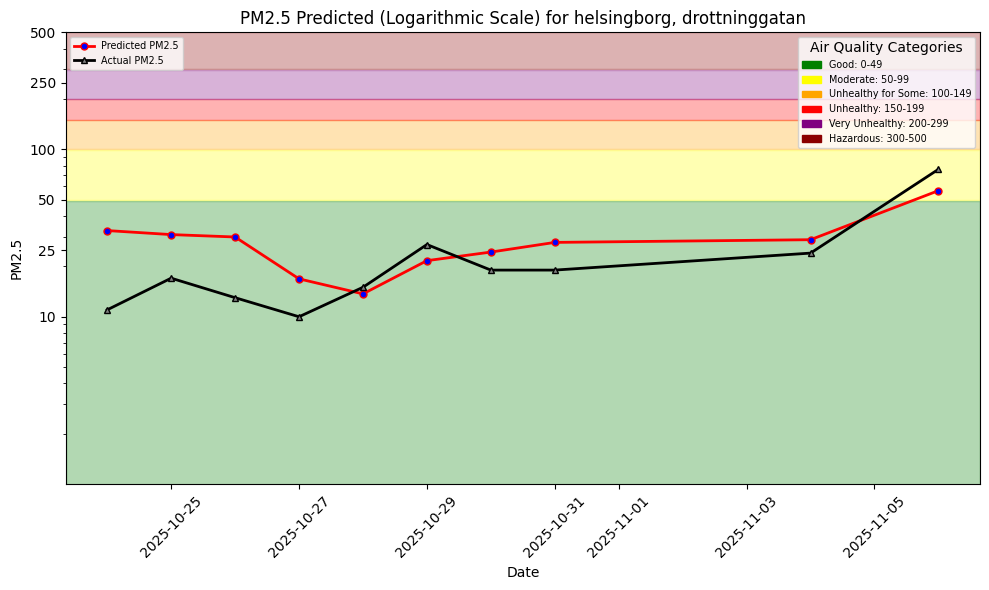

In [ ]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day_{id}.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [21]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /Users/selinaliu/Desktop/大四上/DL/mlfs-book/docs/air-quality/assets/img/pm25_forecast.png: 0.000%|    …

Uploading /Users/selinaliu/Desktop/大四上/DL/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day.png: 0.000%…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1279139/settings/fb/path/Resources/airquality


---